### Improving lstm prediction
- Add more lags (e.g 24 i.e 2 years)
- Add more epochs (e.g. 5)
- Add layers, early stopping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scalecast.Forecaster import Forecaster

In [3]:
df = pd.read_csv('D:\\PythonProjects\\DataSets\\AirPassengers.csv', parse_dates = ['Month'])

In [4]:
df = df.sort_values(['Month'])

In [5]:
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
f = Forecaster(
    y=df['Passengers'],  #df.iloc[:, 0] ,   #passengers column 0th col
    current_dates=df['Month'],
    #cis = True,
)

In [7]:
f.generate_future_dates(12) # 12-month forecast horizon
f.set_test_length(12) # 20% test set

In [8]:
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=12
    Xvars=[]
    Differenced=0
    TestLength=12
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

<AxesSubplot:xlabel='Date', ylabel='Values'>

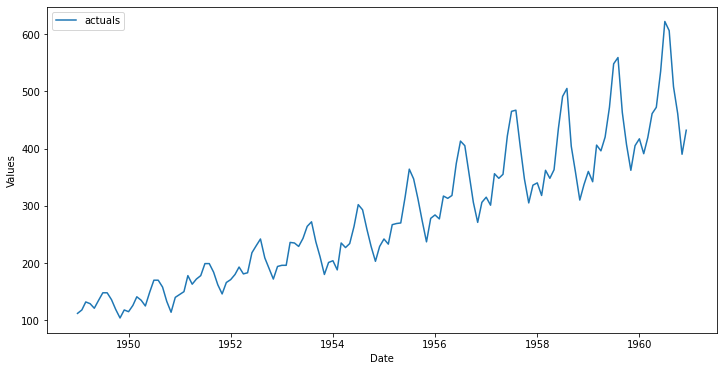

In [9]:
f.plot()

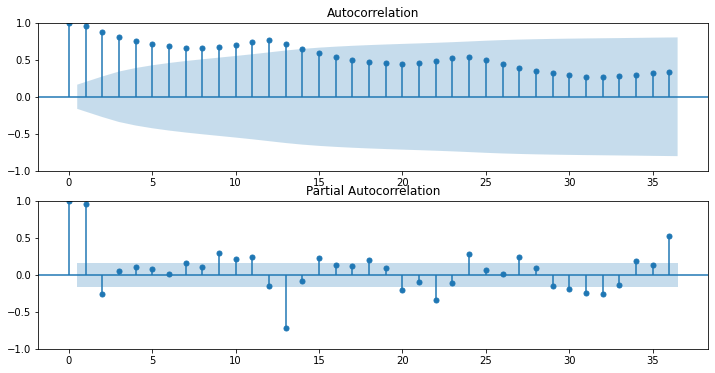

In [34]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

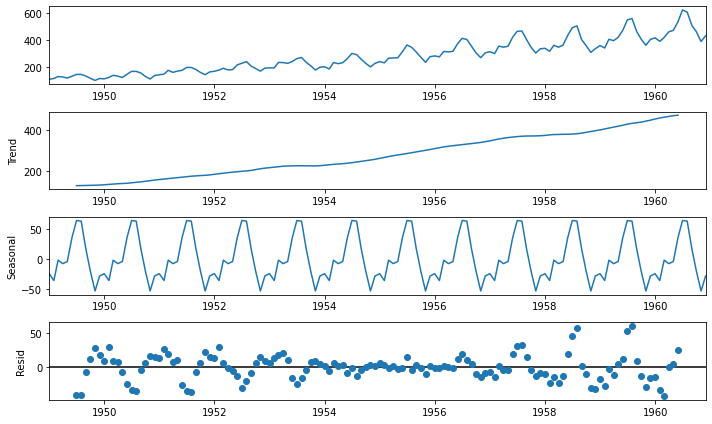

In [11]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

In [12]:
f.set_estimator('lstm')

#### Approach1 - LSTM default

LSTM default, 
- this model runs with a single input layer of 8 size, 
- Adam optimizer, tanh activation, 
- a single lagged dependent-variable value to train with, 
- learning rate of 0.001, and no dropout. 
- All data is scaled going into the model with a min-max scaler and un-scaled coming out. 
- f.manual_forecast( ) is similar to the fit() method in TensorFlow

In [13]:
f.manual_forecast(call_me='lstm_default')

5/5 [==============================] - 2s 7ms/step - loss: 0.3372


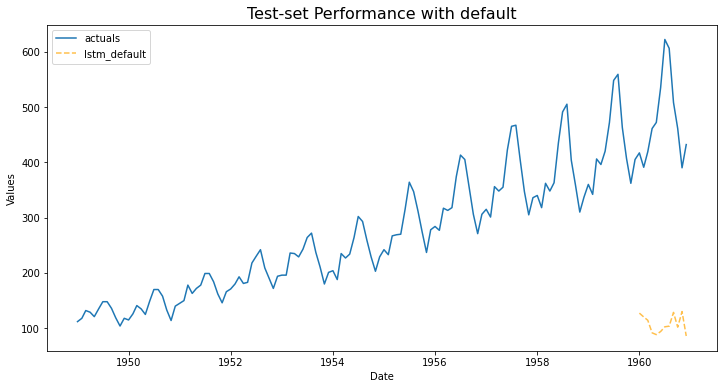

In [14]:
f.plot_test_set()
plt.title('Test-set Performance with default',size=16)
plt.show()

#### Approach2 - Add lags

- There is significant autocorrelation of 24 months (i.e. 2 yrs) in the PACF 

In [15]:
#add lags for 2 years (24 months) 
f.manual_forecast(call_me='lstm_24lags',lags=24)

4/4 [==============================] - 2s 10ms/step - loss: 0.4182


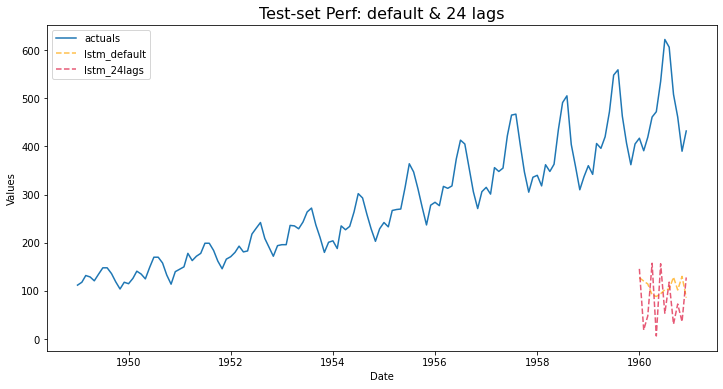

In [16]:
f.plot_test_set()
plt.title('Test-set Perf: default & 24 lags',size=16)
plt.show()

#### Approach 3: Add epochs (to lags)
- Give more time to train (i.e add more epochs)
- Also validate the model while it’s training by specifying validation_split=.2

In [17]:
#add 5 epochs to lags
f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5,validation_split=.2,shuffle=True)

#f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5)

Epoch 1/5
3/3 [==============================] - 3s 342ms/step - loss: 0.4729 - val_loss: 0.1948
Epoch 2/5
3/3 [==============================] - 0s 28ms/step - loss: 0.4628 - val_loss: 0.1880
Epoch 3/5
3/3 [==============================] - 0s 25ms/step - loss: 0.4527 - val_loss: 0.1812
Epoch 4/5
3/3 [==============================] - 0s 25ms/step - loss: 0.4424 - val_loss: 0.1744
Epoch 5/5
3/3 [==============================] - 0s 32ms/step - loss: 0.4320 - val_loss: 0.1675
Epoch 1/5
3/3 [==============================] - 2s 214ms/step - loss: 0.4161 - val_loss: 0.1597
Epoch 2/5
3/3 [==============================] - 0s 25ms/step - loss: 0.4053 - val_loss: 0.1524
Epoch 3/5
3/3 [==============================] - 0s 28ms/step - loss: 0.3943 - val_loss: 0.1451
Epoch 4/5
3/3 [==============================] - 0s 27ms/step - loss: 0.3827 - val_loss: 0.1376
Epoch 5/5
3/3 [==============================] - 0s 29ms/step - loss: 0.3712 - val_loss: 0.1303


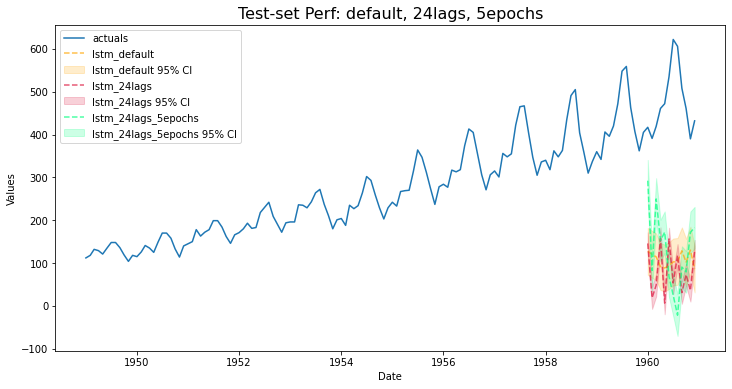

In [18]:
f.plot_test_set(ci=True)
plt.title('Test-set Perf: default, 24lags, 5epochs',size=16)
plt.show()

#### Approach 4: Add Layers and early Stopping
- Using Approach 3, some values fall within 95% confidence interval
- So increase the number of layers in the network to 3, increasing epochs to 25,
- Early Stopping: Monitor the validation loss value and  quit after more than 5 iterations in which model doesn’t improve 

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=5
    ),
   # lstm_layer_sizes=(16,16,16),
    lstm_layer_sizes=(16,)*3,
    dropout=(0,0,0)
)


Epoch 1/25
3/3 [==============================] - 6s 538ms/step - loss: 0.4665 - val_loss: 0.1906
Epoch 2/25
3/3 [==============================] - 0s 32ms/step - loss: 0.4544 - val_loss: 0.1812
Epoch 3/25
3/3 [==============================] - 0s 43ms/step - loss: 0.4399 - val_loss: 0.1694
Epoch 4/25
3/3 [==============================] - 0s 57ms/step - loss: 0.4212 - val_loss: 0.1538
Epoch 5/25
3/3 [==============================] - 0s 60ms/step - loss: 0.3960 - val_loss: 0.1348
Epoch 6/25
3/3 [==============================] - 0s 57ms/step - loss: 0.3619 - val_loss: 0.1220
Epoch 7/25
3/3 [==============================] - 0s 46ms/step - loss: 0.3241 - val_loss: 0.1217
Epoch 8/25
3/3 [==============================] - 0s 56ms/step - loss: 0.2868 - val_loss: 0.1324
Epoch 9/25
3/3 [==============================] - 0s 55ms/step - loss: 0.2520 - val_loss: 0.1589
Epoch 10/25
3/3 [==============================] - 0s 64ms/step - loss: 0.2286 - val_loss: 0.1776
Epoch 11/25
3/3 [===========

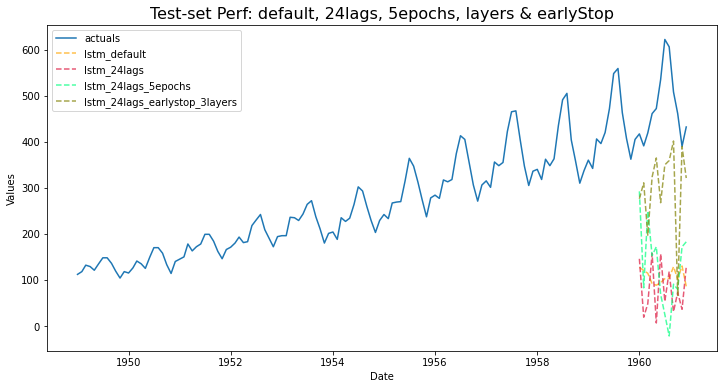

In [21]:
f.plot_test_set()
plt.title('Test-set Perf: default, 24lags, 5epochs, layers & earlyStop',size=16)
plt.show()

#### Approach 5: Add more lags and layers
- Follow the process of finding combination of lags, epochs, layer size .. 
- One such combination of 36 lags, 15 epochs, layer 72 x 4
- Plot loss to see the improvement

Epoch 1/15
3/3 [==============================] - 8s 787ms/step - loss: 0.4846 - val_loss: 0.2072
Epoch 2/15
3/3 [==============================] - 0s 91ms/step - loss: 0.3967 - val_loss: 0.1023
Epoch 3/15
3/3 [==============================] - 0s 124ms/step - loss: 0.1981 - val_loss: 0.1216
Epoch 4/15
3/3 [==============================] - 0s 121ms/step - loss: 0.1279 - val_loss: 0.0571
Epoch 5/15
3/3 [==============================] - 0s 129ms/step - loss: 0.1132 - val_loss: 0.1071
Epoch 6/15
3/3 [==============================] - 0s 116ms/step - loss: 0.1295 - val_loss: 0.0915
Epoch 7/15
3/3 [==============================] - 0s 118ms/step - loss: 0.1093 - val_loss: 0.0564
Epoch 8/15
3/3 [==============================] - 0s 117ms/step - loss: 0.1114 - val_loss: 0.0608
Epoch 9/15
3/3 [==============================] - 0s 107ms/step - loss: 0.1006 - val_loss: 0.0723
Epoch 10/15
3/3 [==============================] - 0s 123ms/step - loss: 0.1000 - val_loss: 0.0529
Epoch 11/15
3/3 [===

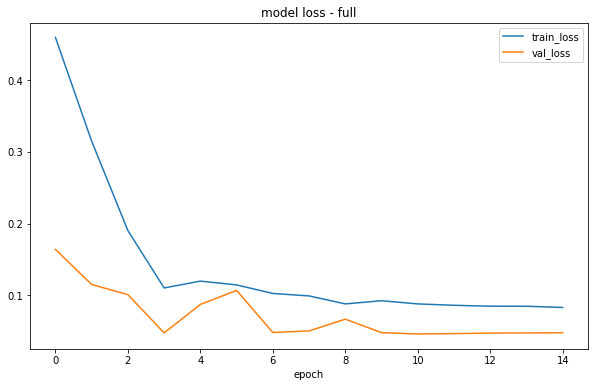

In [22]:
f.manual_forecast(
    call_me='lstm_36lags_4layers_15epochs',
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True
)

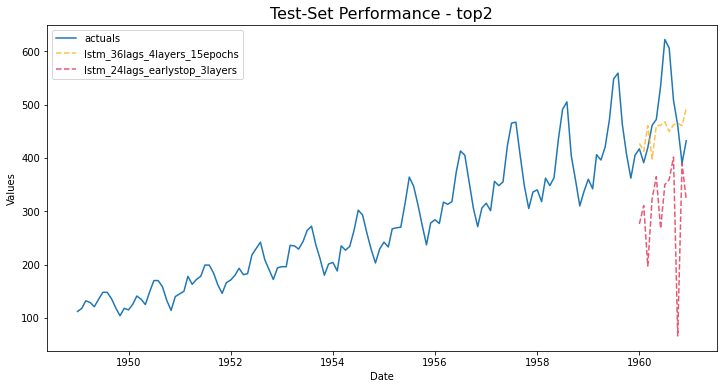

In [23]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2')
plt.title('Test-Set Performance - top2',size=16)
plt.show()


#### Approach 6: Add many more layers and large epochs 

Epoch 1/300
5/5 [==============================] - 33s 3s/step - loss: 0.4634 - val_loss: 0.2672
Epoch 2/300
5/5 [==============================] - 6s 1s/step - loss: 0.2055 - val_loss: 0.2585
Epoch 3/300
5/5 [==============================] - 6s 1s/step - loss: 0.1592 - val_loss: 0.2174
Epoch 4/300
5/5 [==============================] - 6s 1s/step - loss: 0.1500 - val_loss: 0.1125
Epoch 5/300
5/5 [==============================] - 7s 1s/step - loss: 0.1936 - val_loss: 0.1603
Epoch 6/300
5/5 [==============================] - 7s 1s/step - loss: 0.1642 - val_loss: 0.2577
Epoch 7/300
5/5 [==============================] - 6s 1s/step - loss: 0.1298 - val_loss: 0.1339
Epoch 8/300
5/5 [==============================] - 5s 1s/step - loss: 0.1393 - val_loss: 0.1546
Epoch 9/300
5/5 [==============================] - 6s 1s/step - loss: 0.1225 - val_loss: 0.1775
Epoch 10/300
5/5 [==============================] - 6s 1s/step - loss: 0.1301 - val_loss: 0.1420
Epoch 11/300
5/5 [====================

5/5 [==============================] - 6s 1s/step - loss: 0.0851 - val_loss: 0.0590
Epoch 86/300
5/5 [==============================] - 6s 1s/step - loss: 0.0877 - val_loss: 0.0590
Epoch 87/300
5/5 [==============================] - 5s 1s/step - loss: 0.0830 - val_loss: 0.0620
Epoch 88/300
5/5 [==============================] - 6s 1s/step - loss: 0.0841 - val_loss: 0.0579
Epoch 89/300
5/5 [==============================] - 6s 1s/step - loss: 0.0815 - val_loss: 0.0791
Epoch 90/300
5/5 [==============================] - 6s 1s/step - loss: 0.0859 - val_loss: 0.0562
Epoch 91/300
5/5 [==============================] - 6s 1s/step - loss: 0.1009 - val_loss: 0.0543
Epoch 92/300
5/5 [==============================] - 5s 1s/step - loss: 0.0965 - val_loss: 0.0818
Epoch 93/300
5/5 [==============================] - 6s 1s/step - loss: 0.0908 - val_loss: 0.0556
Epoch 94/300
5/5 [==============================] - 5s 1s/step - loss: 0.0954 - val_loss: 0.0852
Epoch 95/300
5/5 [=========================

Epoch 169/300
5/5 [==============================] - 5s 1s/step - loss: 0.0771 - val_loss: 0.0568
Epoch 170/300
5/5 [==============================] - 6s 1s/step - loss: 0.0811 - val_loss: 0.0627
Epoch 171/300
5/5 [==============================] - 5s 1s/step - loss: 0.0794 - val_loss: 0.0561
Epoch 172/300
5/5 [==============================] - 7s 1s/step - loss: 0.0735 - val_loss: 0.0604
Epoch 173/300
5/5 [==============================] - 6s 1s/step - loss: 0.0724 - val_loss: 0.0686
Epoch 174/300
5/5 [==============================] - 5s 996ms/step - loss: 0.0686 - val_loss: 0.0630
Epoch 175/300
5/5 [==============================] - 6s 1s/step - loss: 0.0713 - val_loss: 0.0626
Epoch 176/300
5/5 [==============================] - 6s 1s/step - loss: 0.0716 - val_loss: 0.0615
Epoch 177/300
5/5 [==============================] - 6s 1s/step - loss: 0.0765 - val_loss: 0.0646
Epoch 178/300
5/5 [==============================] - 6s 1s/step - loss: 0.0725 - val_loss: 0.0579
Epoch 179/300
5/5

5/5 [==============================] - 5s 1s/step - loss: 0.0384 - val_loss: 0.0525
Epoch 253/300
5/5 [==============================] - 7s 1s/step - loss: 0.0410 - val_loss: 0.0497
Epoch 254/300
5/5 [==============================] - 6s 1s/step - loss: 0.0483 - val_loss: 0.0789
Epoch 255/300
5/5 [==============================] - 6s 1s/step - loss: 0.0431 - val_loss: 0.0477
Epoch 256/300
5/5 [==============================] - 6s 1s/step - loss: 0.0432 - val_loss: 0.0457
Epoch 257/300
5/5 [==============================] - 6s 1s/step - loss: 0.0400 - val_loss: 0.0465
Epoch 258/300
5/5 [==============================] - 6s 1s/step - loss: 0.0448 - val_loss: 0.0628
Epoch 259/300
5/5 [==============================] - 6s 1s/step - loss: 0.0464 - val_loss: 0.0515
Epoch 260/300
5/5 [==============================] - 6s 1s/step - loss: 0.0425 - val_loss: 0.0600
Epoch 261/300
5/5 [==============================] - 6s 1s/step - loss: 0.0447 - val_loss: 0.0489
Epoch 262/300
5/5 [===============

5/5 [==============================] - 5s 938ms/step - loss: 0.0850 - val_loss: 0.0529
Epoch 36/300
5/5 [==============================] - 5s 962ms/step - loss: 0.0836 - val_loss: 0.0522
Epoch 37/300
5/5 [==============================] - 5s 978ms/step - loss: 0.0861 - val_loss: 0.0536
Epoch 38/300
5/5 [==============================] - 5s 966ms/step - loss: 0.0896 - val_loss: 0.0548
Epoch 39/300
5/5 [==============================] - 4s 886ms/step - loss: 0.0879 - val_loss: 0.0623
Epoch 40/300
5/5 [==============================] - 5s 1s/step - loss: 0.0847 - val_loss: 0.0483
Epoch 41/300
5/5 [==============================] - 5s 917ms/step - loss: 0.0841 - val_loss: 0.0501
Epoch 42/300
5/5 [==============================] - 5s 944ms/step - loss: 0.0834 - val_loss: 0.0539
Epoch 43/300
5/5 [==============================] - 5s 994ms/step - loss: 0.0821 - val_loss: 0.0511
Epoch 44/300
5/5 [==============================] - 4s 883ms/step - loss: 0.0828 - val_loss: 0.0513
Epoch 45/300
5/5

5/5 [==============================] - 5s 999ms/step - loss: 0.0837 - val_loss: 0.0543
Epoch 119/300
5/5 [==============================] - 5s 1s/step - loss: 0.0814 - val_loss: 0.0586
Epoch 120/300
5/5 [==============================] - 5s 1s/step - loss: 0.0800 - val_loss: 0.0653
Epoch 121/300
5/5 [==============================] - 5s 1s/step - loss: 0.0798 - val_loss: 0.0549
Epoch 122/300
5/5 [==============================] - 5s 1s/step - loss: 0.0810 - val_loss: 0.0740
Epoch 123/300
5/5 [==============================] - 5s 986ms/step - loss: 0.0807 - val_loss: 0.0486
Epoch 124/300
5/5 [==============================] - 5s 1s/step - loss: 0.0775 - val_loss: 0.0560
Epoch 125/300
5/5 [==============================] - 5s 1s/step - loss: 0.0787 - val_loss: 0.0484
Epoch 126/300
5/5 [==============================] - 5s 1s/step - loss: 0.0862 - val_loss: 0.0486
Epoch 127/300
5/5 [==============================] - 5s 996ms/step - loss: 0.0801 - val_loss: 0.0473
Epoch 128/300
5/5 [======

5/5 [==============================] - 5s 1s/step - loss: 0.0588 - val_loss: 0.0432
Epoch 202/300
5/5 [==============================] - 5s 1s/step - loss: 0.0574 - val_loss: 0.0435
Epoch 203/300
5/5 [==============================] - 5s 1s/step - loss: 0.0571 - val_loss: 0.0468
Epoch 204/300
5/5 [==============================] - 5s 1s/step - loss: 0.0547 - val_loss: 0.0515
Epoch 205/300
5/5 [==============================] - 5s 1s/step - loss: 0.0554 - val_loss: 0.0415
Epoch 206/300
5/5 [==============================] - 5s 997ms/step - loss: 0.0532 - val_loss: 0.0521
Epoch 207/300
5/5 [==============================] - 5s 1s/step - loss: 0.0542 - val_loss: 0.0558
Epoch 208/300
5/5 [==============================] - 5s 1s/step - loss: 0.0635 - val_loss: 0.0718
Epoch 209/300
5/5 [==============================] - 5s 1s/step - loss: 0.0653 - val_loss: 0.0640
Epoch 210/300
5/5 [==============================] - 5s 1s/step - loss: 0.0671 - val_loss: 0.0480
Epoch 211/300
5/5 [============

5/5 [==============================] - 5s 1s/step - loss: 0.0312 - val_loss: 0.0333
Epoch 285/300
5/5 [==============================] - 5s 1s/step - loss: 0.0288 - val_loss: 0.0362
Epoch 286/300
5/5 [==============================] - 5s 1s/step - loss: 0.0303 - val_loss: 0.0347
Epoch 287/300
5/5 [==============================] - 6s 1s/step - loss: 0.0308 - val_loss: 0.0384
Epoch 288/300
5/5 [==============================] - 5s 919ms/step - loss: 0.0327 - val_loss: 0.0405
Epoch 289/300
5/5 [==============================] - 5s 1s/step - loss: 0.0322 - val_loss: 0.0339
Epoch 290/300
5/5 [==============================] - 5s 1s/step - loss: 0.0280 - val_loss: 0.0329
Epoch 291/300
5/5 [==============================] - 5s 1s/step - loss: 0.0251 - val_loss: 0.0365
Epoch 292/300
5/5 [==============================] - 5s 996ms/step - loss: 0.0264 - val_loss: 0.0332
Epoch 293/300
5/5 [==============================] - 6s 1s/step - loss: 0.0285 - val_loss: 0.0345
Epoch 294/300
5/5 [=========

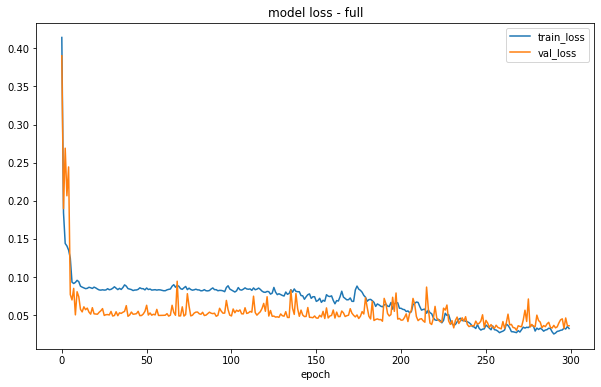

In [28]:
f.manual_forecast(
    call_me='lstm_best',
    lags=36,
    batch_size=16,
    epochs= 300, #30,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(100,)*15,
    dropout=(0,)*15,
    plot_loss=True,
)

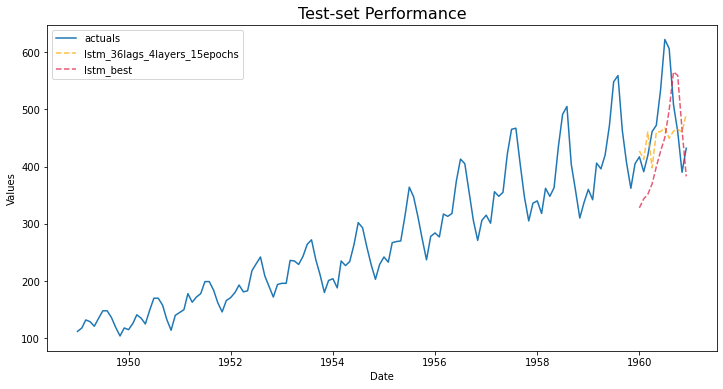

In [29]:
f.plot_test_set(order_by='LevelTestSetMAPE',models=['lstm_best','lstm_36lags_4layers_15epochs'])
plt.title('Test-set Performance',size=16)
plt.show()

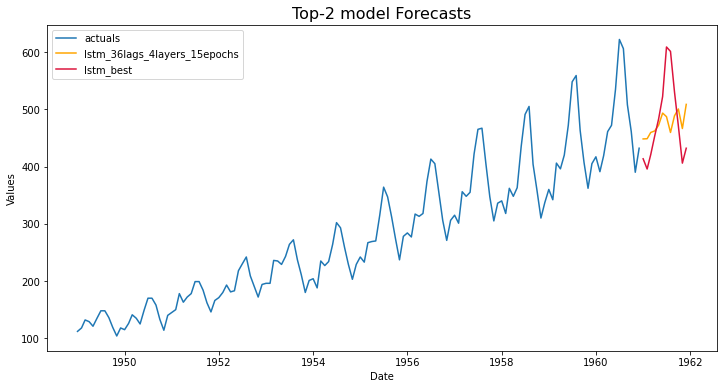

In [30]:
f.plot(order_by='TestSetMAPE',models=['lstm_best','lstm_36lags_4layers_15epochs'])
plt.title('Top-2 model Forecasts',size=16)
plt.show()

#### Benchmarking

In [32]:
f.export('model_summaries',determine_best_by='TestSetMAPE')[
    ['ModelNickname','TestSetMAPE','TestSetRMSE']
]

,ModelNickname,TestSetMAPE,TestSetRMSE
0,lstm_36lags_4layers_15epochs,0.117054,76.954218
1,lstm_best,0.177740,92.069138
2,lstm_24lags_earlystop_3layers,0.355628,202.494682
3,lstm_24lags_5epochs,0.704142,378.829700
4,lstm_default,0.767292,377.453425
5,lstm_24lags,0.829153,403.982398
